In [1]:
import os
import glob
import wget
import re
import datetime
import astropy
from astropy.time import Time

# plotting and data management
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio
from rasterio.plot import show as rioshow

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Polygon
from geospatial_functions import get_background_map

# scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
# loading other layers
outline            = gpd.read_file(f"Data\\lena_basin_outline_polygon.gpkg",driver="GPKG")
main_rivers        = gpd.read_file(f"Data\\lena_main_river.gpkg",driver="GPKG") 
coast              = gpd.read_file(f"Data\\north_east_russian_coastlines.gpkg",driver="GPKG") 
eurasian_coast     = gpd.read_file(f"Data\\eurasian_coastlines.gpkg",driver="GPKG") 
all_eurasian_coast = gpd.read_file(f"Data\\all_eurasian_coastlines.gpkg",driver="GPKG") 
arctic_basin       = gpd.read_file(f"Data\\basins_arctic_ocean_combined_clipped.gpkg",driver="GPKG") 
arctic_rivers      = gpd.read_file(f"Data\\rivers_arctic_ocean_O_6.gpkg",driver="GPKG") 

# fixing crs
for layer in [outline,main_rivers,coast]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [3]:
crs = "epsg:3395"
outline_local_crs = outline.copy()
outline_local_crs.geometry = outline_local_crs.geometry.to_crs(crs)
main_rivers_local = main_rivers.copy()
main_rivers_local.geometry = main_rivers_local.geometry.to_crs(crs)

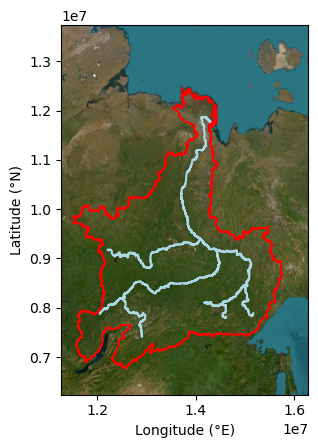

In [4]:
fig, ax  = plt.subplots()
outline_local_crs.plot(ax=ax,edgecolor='red',zorder=10,facecolor="None")
main_rivers_local.plot(ax=ax, color='lightblue')

bounds_stations = (101.493054253, 50.88931030940004, 143.43669891900012, 75.08938842260008) # from epsg plot
with rasterio.open(get_background_map("outline", bounds_stations,crs)) as r:
    rioshow(r, ax=ax,zorder=-10)


ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
fig.savefig("Figures\Lena_Basin_map.png")

In [5]:
print(f"The area of the basin in {outline_local_crs.area.iloc[0]*10**-6:.2f} km^2") # some issue with the projection

The area of the basin in 11254787.18 km^2


In [6]:
area =  2430000 #km^2

In [7]:
def plot_map(ax):
    legend_field = []
    
    # stations
    # gdf_station.loc[[1358000]].plot(ax=ax, markersize=20, color="C1",zorder=10)
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='discharge station'))

    
    outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    # all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    # add background
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    # print(bounds_stations)
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    coast.plot(ax=ax,color='k',zorder=1)
    ax.set_xlim((bounds_stations[0],bounds_stations[2]))
    ax.set_ylim((bounds_stations[1],bounds_stations[3]))
    ax.grid(alpha=0.3)
    ax.set_title("Lena basin")
    ax.set_ylabel("Latitude (°N)")
    ax.set_xlabel("Longitude (°E)")

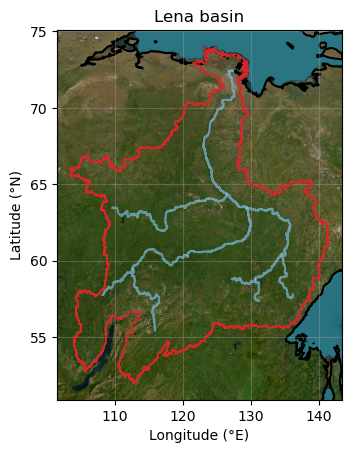

In [8]:
fig, ax = plt.subplots()
plot_map(ax)

fig.savefig("Figures\Lena_Basin_map.png")

In [9]:
def plot_map_overview(ax):
    legend_field = []
    
    # stations
    # gdf_station.loc[[1358000]].plot(ax=ax, markersize=20, color="C1",zorder=10)
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='discharge station'))

    
    outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    # all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    # add background
    eurasian_coast.plot(ax=ax,color='k',zorder=1)
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    # print(bounds_stations)
    with rasterio.open(get_background_map("eurasian_outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    bounds = [60, 10, 150, 80]
    ax.set_xlim((bounds[0],bounds[2]))
    ax.set_ylim((bounds[1],bounds[3]))
    ax.grid(alpha=0.3)
    ax.set_title("Overview of location of lena basin")
    ax.set_ylabel("Latitude (°N)")
    ax.set_xlabel("Longitude (°E)")

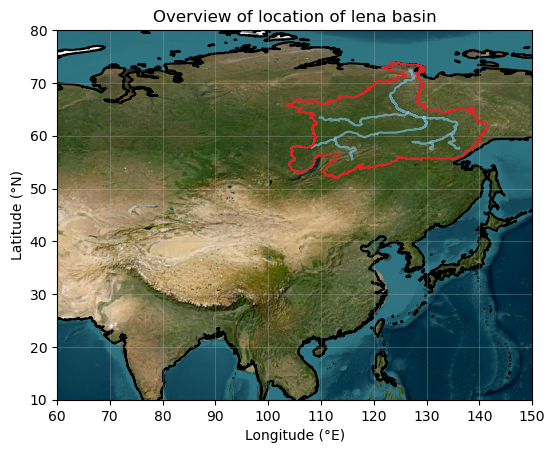

In [10]:
fig, ax = plt.subplots()
plot_map_overview(ax)

fig.savefig("Figures\overview_map.png")

In [11]:
def plot_map_overview_arctic(ax,lena=False):
    legend_field = []
    
    # stations
    # gdf_station.loc[[1358000]].plot(ax=ax, markersize=20, color="C1",zorder=10)
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='discharge station'))

    if not lena:
        arctic_basin.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2,lw=0.8)
        arctic_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=0.5)
    else:
        outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2,lw=0.8)
        main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=0.5)
    # all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    # add background
    all_eurasian_coast.plot(ax=ax,color='k',zorder=1)
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    # print(bounds_stations)
    with rasterio.open(get_background_map("arctic_map2", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    bounds = [35, 10, 180, 80]
    ax.set_xlim((bounds[0],bounds[2]))
    ax.set_ylim((bounds[1],bounds[3]))
    ax.grid(alpha=0.3)
    if not lena:
        ax.set_title("Overview of arctic basins")
    else:
        ax.set_title("Overview of Lena basin")
    ax.set_ylabel("Latitude (°N)")
    ax.set_xlabel("Longitude (°E)")

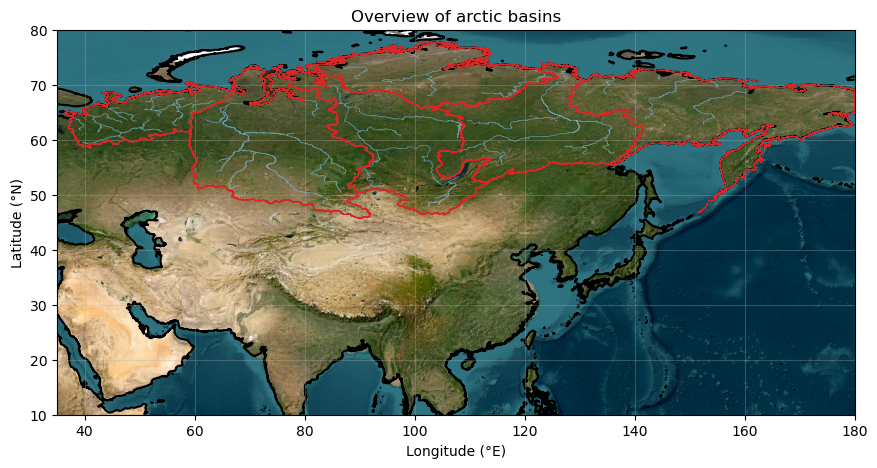

In [40]:
fig, ax = plt.subplots(figsize=(12,5))
plot_map_overview_arctic(ax)
fig.savefig("Figures\\arctic_overview_map.png",bbox_inches="tight")

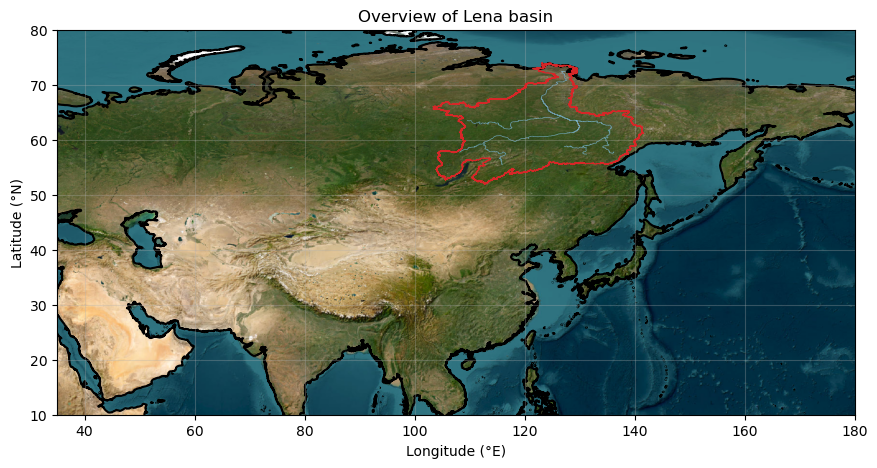

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
plot_map_overview_arctic(ax,lena=True)

fig.savefig("Figures\\arctic_overview_map_lena.png",bbox_inches="tight")

# Q

In [14]:
df = pd.read_excel(f"Data\\Lena_Kyusyur_Version_20230809.xlsx")
df['timestamp'] = df.apply(lambda x: pd.Timestamp(x.date),axis=1)
df.index = df.timestamp

In [15]:
df = df[["discharge"]]

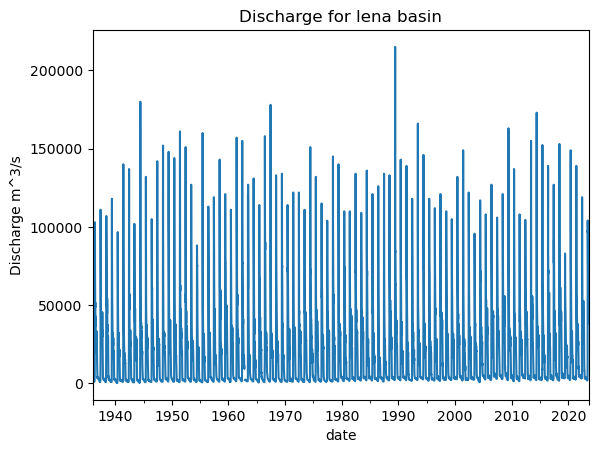

In [16]:
df.discharge.plot()
plt.title('Discharge for lena basin')
plt.ylabel("Discharge m^3/s")
plt.xlabel("date");

In [17]:
df_monthly_Q = df.resample("m").sum()

<Axes: xlabel='timestamp'>

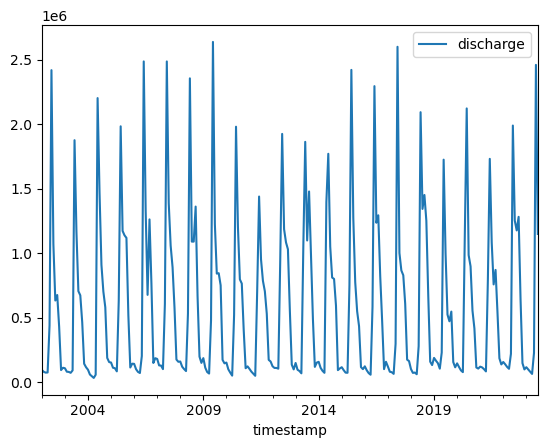

In [18]:
df_monthly_Q.loc["2002":"2023"].plot()

# P & E from era5?

# load grace data

In [19]:
url = "https://ftp.tugraz.at/outgoing/ITSG/GRACE/ITSG-Grace2018/monthly/monthly_n60/"

In [20]:
page = urlopen(url)
html_bytes = page.read()
html = html_bytes.decode("utf-8")

In [21]:
table = html[html.find('<table>'):html.find('</table>')]
table_data = [[cell.text.strip() for cell in row("td")]
                         for row in BeautifulSoup(table)("tr")]
headers = [[cell.text.strip() for cell in row("th")]
                      for row in BeautifulSoup(table)("tr")][0]
table_data = [row for row in table_data if len(row)>2]

In [22]:
array_grace_data_availible = np.array([np.array(row) for row in table_data])[:,1][1:]

In [23]:
if glob.glob('Data\\Grace\*.gfc') == 0: # only run if no data yet
    for grace_data in array_grace_data_availible:
        wget.download(url + grace_data, out=f'Data\\Grace\\{grace_data}')

In [24]:
url_degree_1_stoke_coeff =  "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/grace/open/docs/TN-13_GEOC_CSR_RL0601.txt"
fname1 = f'Data\\Grace\\degree1_stokes_coeff.txt'
if not os.path.exists(fname1):
    wget.download(url_degree_1_stoke_coeff, out=fname1)

In [25]:
url_degree_2_stoke_coeff =  "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/grace/open/docs/TN-14_C30_C20_GSFC_SLR.txt"
fname2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
if not os.path.exists(fname2):
    wget.download(url_degree_2_stoke_coeff, out=fname2)

In [26]:
fname_stoke_coeff2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
# df_stokes_2 = np.loadtxt(fname_stoke_coeff2,skiprows=38) 
#         #names=['GRCOF2',"_1","_2","_3","l","_4","_5","m", "Clm","Slm","sd_Clm","sd_Slm","begin_date","end_date"])

In [27]:
reach_end_of_head = False
list_lines = []
with open(fname_stoke_coeff2) as fin:
    for line in fin:
        line = line.strip()
        if not reach_end_of_head:
            if line.startswith("Product:"):
                reach_end_of_head = True
        else:
            line = line.split(' ')
            line = np.array(line)
            line = line[line!=" "]
            line = line[line!=""]
            list_lines.append(line)
arr_lines = np.array(list_lines)

In [28]:
df_stokes_2_3 = pd.DataFrame(arr_lines,
               columns=['MJD begin',"Year fraction begin","C20","C20 - C20_mean (1.0E-10)","sig_C20 (1.0E-10)",
                                                          "C30","C30 - C30_mean (1.0E-10)","sig_C30 (1.0E-10)",
                    'MJD end',"Year fraction end"
                   ])

In [29]:
def MJD_to_ts(mjd):
    # Start with some time in modified julian date (MJD)
    # Convert to Julian Date
    mjd = float(mjd)
    jd = mjd + 2400000.5
    # Convert to astropy Time object
    t = astropy.time.Time(jd, format='jd')
    # Convert to datetime
    str = t.to_datetime()
    return str

In [30]:
df_stokes_2_3["begin_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3["end_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)

In [31]:
df_stokes_2_3 = df_stokes_2_3[["begin_date","C20","C30","end_date"]].set_index("begin_date")

# load GIA signal

In [32]:
url = "https://www.atmosp.physics.utoronto.ca/~peltier/data.php"

In [33]:
download_url_GIA = "https://www.atmosp.physics.utoronto.ca/~peltier/datasets/Ice6G_C_VM5a/ICE-6G_High_Res_Stokes_trend.txt.gz"

In [34]:
fname_gia = f'Data\\GIA\\GIA_stoke_coeff_trend.gz'
if not os.path.exists(fname_gia):
    wget.download(download_url_GIA, out=fname_gia)

In [35]:
df_1 = pd.read_csv(fname_gia, compression='gzip',skiprows=1,nrows=6,names=["l","m","Clm","Slm"],delimiter="\s+")
df_2 = pd.read_csv(fname_gia, compression='gzip',skiprows=9,nrows=6,names=["l","m","Clm","Slm"],delimiter="\s+")
df_3 = pd.read_csv(fname_gia, compression='gzip',skiprows=17,names=["l","m","Clm","Slm"],delimiter="\s+")

df_combined = pd.concat([df_2, df_3])
df_combined["l"] = df_combined["l"].astype(int)
df_combined["m"] = df_combined["m"].astype(int)

In [36]:
l, m = 60, 60
GIA_C = np.zeros((l, m))
GIA_S = np.zeros((l, m))
for index, row in df_combined.iterrows():
    if row.m < m and row.l < l:
        GIA_C[int(row.m),int(row.l)] = row["Clm"]
        GIA_S[int(row.m),int(row.l)] = row["Slm"]

In [37]:
df_2['Clm'] = df_1['Clm'] + df_2['Clm']
df_2['Slm'] = df_1['Slm'] + df_2['Slm']

In [38]:
df_2

l  m           Clm           Slm
0  0  0 -2.623519e-11  0.000000e+00
1  1  0  9.633173e-13  0.000000e+00
2  1  1  7.817953e-13 -4.186582e-14
3  2  0  2.872648e-11  0.000000e+00
4  2  1 -7.800380e-12  3.622659e-11
5  2  2 -5.988672e-12  1.627878e-13